# Tutorial of EEG band power and psd extraction

This tutorial contains:
1. obtain the **Power Spectral Density (PSD)** of an 1D time-series signal (e.g. EEG signal of one node)
2. obtain the **Band Power** of a specific frequency band of an 1D time-series signal (e.g. EEG signal of one node)
3. **Short time Fourier Transform (STFT)** extractin of an 1D time-series signal (e.g. EEG signal of one node)

## Read data

In [1]:
import numpy as np
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
# data size 1*3000
data = np.loadtxt('sample_data.txt')
# define sampling frequency 100Hz
sf = 100
# define time points 30 sec=3000 points
time = np.arange(data.size)/sf

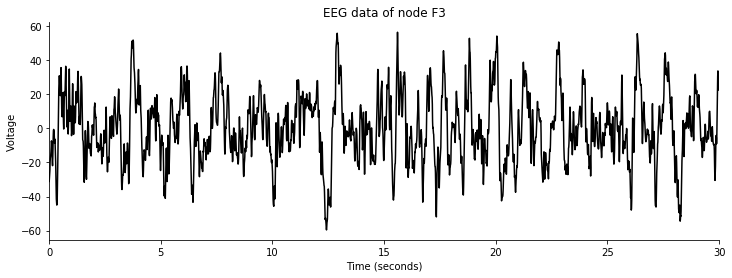

In [3]:
# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data of node F3')
sns.despine()

## Compute PSD

- The Welch method is used to obtain the PSD.
- The Welch method averages consecutive Fourier Transform of **small windows** of the signal, with or without overlapping. 
- A Fourier Transform of a small window results in a PSD of that window.
- The PSD is the Power Distribution over different frequencies. 
- The PSD of an EEG trial is the result of averaging all Fourier Transform of small consecutive windows of an EEG trial. 
- The area under the PSD line is the power of a frequency range.

#### Define small window size
- Fourier Transform is performed over multiple small windows

- The window length should be defined as 2/(lowest frequency of interest).

- Here the window length is 2/0.5Hz = 4 seconds

In [4]:
# Define window length (4 seconds)
lowest_freq = 0.5
win = (2/lowest_freq) * sf
# perform Welch method to obtain PSD
freqs, psd = signal.welch(data, sf, nperseg=win)

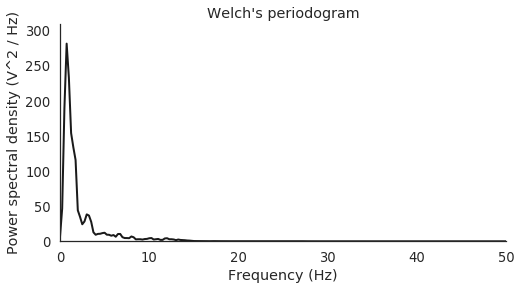

In [5]:
# plot the PSD
# The freqs vector contains the x-axis (frequency).
# The psd vector contains the y-axis (power spectral density). 
# The units of the PSD, when working with EEG data, is usually micro-Volts-squared per Hz (uV^2/Hz).
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

### NOTE
- The only thing that increases **frequency resolution** is time length (small window size). When sampling frequency increases and small window size fixes, the number of sample points in a window increases but the frequency range also increases, so the **frequency resolution** does not change.

- The maximum value of the x-axis (frequency range of PSD) is always half the sampling frequency, which is exactly the Nyquist frequency.

- Increasing the sampling frequency results in a larger frequency range but not higher frequency resolution.

## Extract Band Power
take Delta band (0.5-4Hz) for example

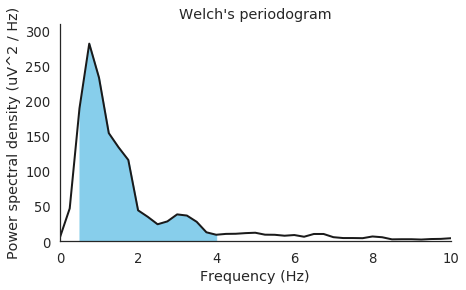

In [6]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

### Obtain absolute band power
- The absolute delta power is equal to the blue area of the previous plot. 
- As there is no closed-form formula to integrate this area, we need to approximate it. This is commonly achieved using the composite Simpson's rule. 

In [7]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 321.064 uV^2


### Obtain relative power
In practice, rather than reporting the absolute band power, one may want to express the power in a frequency band as a percentage of the total power of the signal. This is called the relative band power.

In [8]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.787


## Short time Fourier Transform (STFT) Plot
The unit after STFT when working with EEG signal is uV

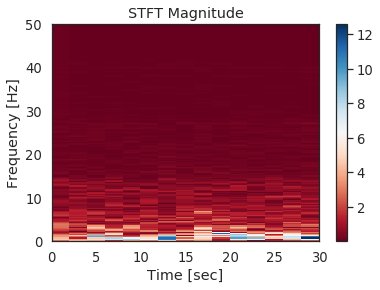

In [9]:
freq, t, Z = signal.stft(data, sf, nperseg=win, noverlap=None)

plt.pcolor(t, freq, np.abs(Z), cmap='RdBu')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()